# Step 1: Import libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

# Step 2: Download and prepare Cats vs Dogs dataset

In [ ]:
import tensorflow as tf
import os
import zipfile

# 1. Download the file
print("Downloading...")
_URL = 'https://download.mlcc.google.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL)

# 2. Extract manually to a specific local directory
local_extract_path = '/tmp/cats_and_dogs_project'
with zipfile.ZipFile(path_to_zip, 'r') as zip_ref:
    zip_ref.extractall(local_extract_path)

# 3. Define the new PATH (The zip usually creates a subfolder with its name)
PATH = os.path.join(local_extract_path, 'cats_and_dogs_filtered')

# 4. Set up the specific directories
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 5. Verify
if os.path.exists(train_cats_dir):
    print("Success! Folders found.")
    print(f"Total training cat images: {len(os.listdir(train_cats_dir))}")
    print(f"Total training dog images: {len(os.listdir(train_dogs_dir))}")
else:
    print("Still not found. Let's see what is actually inside the folder:")
    print(os.listdir(local_extract_path))

Downloading...
68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Success! Folders found.
Total training cat images: 1000
Total training dog images: 1000


# Step 3: Create data generators with augmentation

In [ ]:
IMG_SIZE = (160, 160)          # VGG16 usually expects 224×224, but 160 is faster for demo
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Step 4: Load pre-trained VGG16 (without top classification layers)

In [ ]:
base_model = VGG16(weights='imagenet',
                   include_top=False,           # remove final dense layers
                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Freeze the base model (very important in transfer learning)
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


# Step 5: Build our new model on top of VGG16

In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),          # better than Flatten for conv base
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')     # binary classification → sigmoid
])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 5, 5, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977,857 (57.14 MB)

 Trainable params: 263,169 (1.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Step 6: Compile the model

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Step 7: Train the top layers first (feature extractor frozen)

In [ ]:
print("\nPhase 1: Training top layers only...")
history_phase1 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=1
)


Phase 1: Training top layers only...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 342ms/step - accuracy: 0.9973 - loss: 0.0109 - val_accuracy: 0.9640 - val_loss: 0.1386
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9790 - val_loss: 0.0780
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 352ms/step - accuracy: 0.9976 - loss: 0.0077 - val_accuracy: 0.9730 - val_loss: 0.0918
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 345ms/step - accuracy: 0.9969 - loss: 0.0086 - val_accuracy: 0.9670 - val_loss: 0.1293
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 340ms/step - accuracy: 0.9964 - loss: 0.0135 - val_accuracy: 0.9690 - val_loss: 0.0834
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.9863 - loss: 0.0242 - val_accuracy: 0.9760 - val_loss: 0.0912
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.9980 - loss: 0.0056 - val_accuracy: 0.9740 - val_loss: 0.1321
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 347ms/step - accu

# Step 8: Unfreeze some layers and fine-tune (optional Phase 2)

In [ ]:
print("\nUnfreezing last few conv blocks for fine-tuning...")
base_model.trainable = True
# Freeze all layers except the last 4 blocks (example)
for layer in base_model.layers[:-16]:
    layer.trainable = False
# Re-compile with lower learning rate (very important!)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
print("Phase 2: Fine-tuning...")
history_phase2 = model.fit(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    verbose=1
)


Unfreezing last few conv blocks for fine-tuning...
Phase 2: Fine-tuning...
Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 33s 422ms/step - accuracy: 0.9974 - loss: 0.0082 - val_accuracy: 0.9750 - val_loss: 0.0862
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.9985 - loss: 0.0052 - val_accuracy: 0.9800 - val_loss: 0.0830
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.9995 - loss: 0.0018 - val_accuracy: 0.9760 - val_loss: 0.1024
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 348ms/step - accuracy: 0.9972 - loss: 0.0103 - val_accuracy: 0.9730 - val_loss: 0.0958
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.9830 - val_loss: 0.0713
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 343ms/step - accuracy: 0.9989 - loss: 0.0037 - val_accuracy: 0.9790 - val_loss: 0.0755
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.9800 - val_loss: 0.0892
Epoch 8/30
63/63 ━━━━

# Step 9: Plot training history

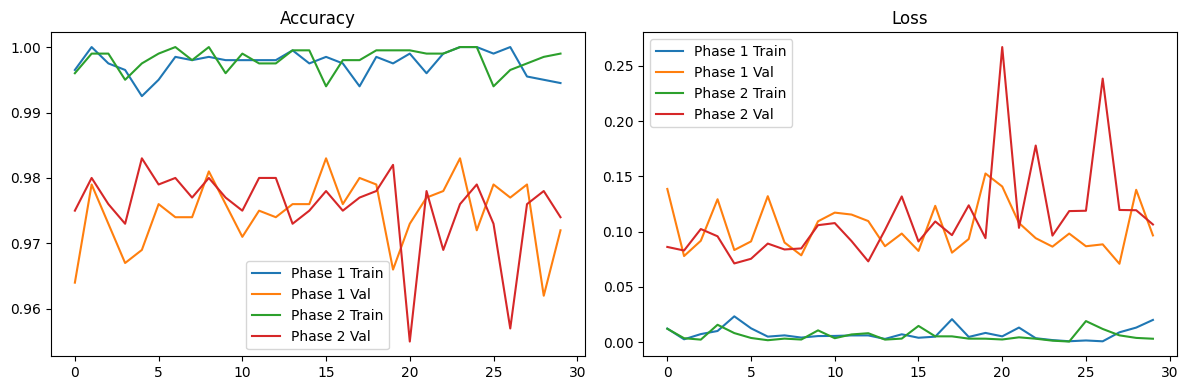

In [ ]:
def plot_history(histories, titles):
    plt.figure(figsize=(12, 4))
    for i, hist in enumerate(histories):
        plt.subplot(1, 2, 1)
        plt.plot(hist.history['accuracy'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_accuracy'], label=f'{titles[i]} Val')
        plt.title('Accuracy')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(hist.history['loss'], label=f'{titles[i]} Train')
        plt.plot(hist.history['val_loss'], label=f'{titles[i]} Val')
        plt.title('Loss')
        plt.legend()
    plt.tight_layout()
    plt.show()
plot_history([history_phase1, history_phase2], ['Phase 1', 'Phase 2'])


# Step 10: Evaluate final model

In [ ]:
loss, acc = model.evaluate(validation_generator, verbose=0)
print(f"\nFinal validation accuracy: {acc:.4f} ({acc*100:.2f}%)")
# Optional: Save model
# model.save("vgg16_cats_dogs_transfer.h5")
print("Practical 2 completed.")


Final validation accuracy: 0.9740 (97.40%)
Practical 2 completed.
